In [1]:
import numpy as np 
import pandas as pd 
import os 
import gudhi as gd

from data_processor import data_processor as dp
from metrics import metrics as met
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import networkx as nx

from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from hyppo.independence import Hsic
from matplotlib import cm
from dtw import *
import pickle
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

from sklearn.manifold import MDS




Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Path to your folder
folder_path = 'data/mehli_dp'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Extract name before the first underscore
        df_name = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        dataframes[df_name] = pd.read_csv(file_path)

##################################################################

file_paths = [
    "LOSGuidanceProportional1_20250819_185911_666879.csv",
    "OceanCurrent1_20250819_185911_666738.csv",
    #"VesselModel3DOFWindCurrent1_20250819_185911_666320.csv",
    #"WaypointManager1_20250819_185911_666638.csv",
    "WindModel3DOF1_20250819_185911_666809.csv"
]


# Read and rename columns to avoid collisions, except for the 'time' column
dfs = []
for path in file_paths:
    print("Loading: "+ str(folder_path+"/"+path))
    df = pd.read_csv(folder_path+"/"+path)
    print("df columns are: "+ str(df.columns))
    df=df.drop(columns=["StepCount"])
    dfs.append(df)

df = dfs[0]# Merge all dataframes on the 'time' column using outer join
for dfr in dfs[1:]:
    df = pd.merge(df, dfr, on="Time", how="outer")

Loading: data/mehli_dp/LOSGuidanceProportional1_20250819_185911_666879.csv
df columns are: Index(['Time', 'StepCount', 'look_ahead_distance_meter', 'prev_wp_x',
       'prev_wp_y', 'next_wp_x', 'next_wp_y', 'os_x', 'os_y',
       'final_heading_rad', 'chi_desired_rad', 'chi_desired_deg',
       'last_wp_active'],
      dtype='object')
Loading: data/mehli_dp/OceanCurrent1_20250819_185911_666738.csv
df columns are: Index(['Time', 'StepCount', 'V_current', 'psi_current_deg', 'ramp_duration',
       'psi', 'u_current', 'v_current', 'r_current', 'enable_ramp'],
      dtype='object')
Loading: data/mehli_dp/WindModel3DOF1_20250819_185911_666809.csv
df columns are: Index(['Time', 'StepCount', 'V_wind', 'psi_wind_deg', 'ramp_duration', 'psi',
       'u', 'v', 'tau_wind_surge', 'tau_wind_sway', 'tau_wind_yaw',
       'enable_ramp'],
      dtype='object')


In [3]:
df

,Time,look_ahead_distance_meter,prev_wp_x,prev_wp_y,next_wp_x,next_wp_y,os_x,os_y,final_heading_rad,chi_desired_rad,...,V_wind,psi_wind_deg,ramp_duration_y,psi_y,u,v,tau_wind_surge,tau_wind_sway,tau_wind_yaw,enable_ramp_y
0,0,50.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,4.0,40.0,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,50.0,0.0,0.0,-140.0,-190.0,-140.000000,-190.000000,0.00000,-2.205823,...,4.0,40.0,50.0,0.610865,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1
2,2,50.0,-140.0,-190.0,-30.0,-100.0,-140.000000,-190.000000,0.00000,0.685730,...,4.0,40.0,50.0,0.610865,0.100889,0.002764,-0.867404,-9.921669,-772.251409,1
3,3,50.0,-140.0,-190.0,-30.0,-100.0,-139.918942,-189.939869,0.00000,0.685825,...,4.0,40.0,50.0,0.608774,0.190800,0.028229,-3.326190,-46.712981,-3783.121916,1
4,4,50.0,-140.0,-190.0,-30.0,-100.0,-139.788526,-189.790258,0.00000,0.685161,...,4.0,40.0,50.0,0.604657,0.271546,0.023413,-6.474791,-90.909896,-7362.143171,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,50.0,-10.0,-50.0,0.0,5.0,0.189400,5.739044,0.18326,0.183260,...,4.0,40.0,50.0,0.203224,0.313156,-0.952935,580.628970,-7368.499767,-930890.540957,1
997,997,50.0,-10.0,-50.0,0.0,5.0,0.188452,5.734955,0.18326,0.183260,...,4.0,40.0,50.0,0.203210,0.313177,-0.952912,580.635964,-7368.481815,-930889.922781,1
998,998,50.0,-10.0,-50.0,0.0,5.0,0.187508,5.730886,0.18326,0.183260,...,4.0,40.0,50.0,0.203197,0.313198,-0.952890,580.642949,-7368.463788,-930889.294730,1
999,999,50.0,-10.0,-50.0,0.0,5.0,0.186568,5.726836,0.18326,0.183260,...,4.0,40.0,50.0,0.203184,0.313219,-0.952868,580.649927,-7368.445683,-930888.656530,1


In [4]:
df.columns, len(df.columns)

(Index(['Time', 'look_ahead_distance_meter', 'prev_wp_x', 'prev_wp_y',
        'next_wp_x', 'next_wp_y', 'os_x', 'os_y', 'final_heading_rad',
        'chi_desired_rad', 'chi_desired_deg', 'last_wp_active', 'V_current',
        'psi_current_deg', 'ramp_duration_x', 'psi_x', 'u_current', 'v_current',
        'r_current', 'enable_ramp_x', 'V_wind', 'psi_wind_deg',
        'ramp_duration_y', 'psi_y', 'u', 'v', 'tau_wind_surge', 'tau_wind_sway',
        'tau_wind_yaw', 'enable_ramp_y'],
       dtype='object'),
 30)

In [5]:
#If df column has 5 or less unique values drop

for col in df.columns:
    if df[col].nunique() <= 5:
        df.drop(columns=[col], inplace=True)
df.drop(columns=["Time","chi_desired_rad"], inplace=True)
df.columns, len(df.columns)


(Index(['os_x', 'os_y', 'chi_desired_deg', 'psi_x', 'u_current', 'v_current',
        'psi_y', 'u', 'v', 'tau_wind_surge', 'tau_wind_sway', 'tau_wind_yaw'],
       dtype='object'),
 12)

In [6]:
#Columns to drop for now since they dont mean too much to me but will keep it in the sim config. this takes away single value columns and 0 value columns. 
unique_and_zero_columns = df.columns[(df.nunique() == 1) | (df == 0).all()]
print(unique_and_zero_columns)
df_cleaned = df.drop(columns=unique_and_zero_columns)
#Will also take away the redudant sway and surge columns for ground since there is no real current water and ground are exactly the same
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('ground', case=False)]
print(df_cleaned.columns, len(df_cleaned.columns))


Index([], dtype='object')
Index(['os_x', 'os_y', 'chi_desired_deg', 'psi_x', 'u_current', 'v_current',
       'psi_y', 'u', 'v', 'tau_wind_surge', 'tau_wind_sway', 'tau_wind_yaw'],
      dtype='object') 12


In [7]:
def distance_correlation(x, y):
    x = x[:, None]
    y = y[:, None]
    a = np.abs(x - x.T)
    b = np.abs(y - y.T)
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    dcov = np.sqrt((A * B).mean())
    dvar_x = np.sqrt((A * A).mean())
    dvar_y = np.sqrt((B * B).mean())
    return dcov / np.sqrt(dvar_x * dvar_y) if dvar_x > 0 and dvar_y > 0 else 0


In [8]:
scaler = StandardScaler()
df_norm=pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

In [9]:
def compute_pairwise_metrics(df):
    results = []
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            x = df.iloc[:, i].values
            y = df.iloc[:, j].values

            pearson_val, _ = pearsonr(x, y)
            dcor_val = distance_correlation(x, y)
            try:
                dtw_val = dtw(x,y,distance_only=True)
            except ValueError:
                dtw_val= float("nan")
            try:
                hsic_val = Hsic().statistic(np.reshape(x,(-1,1)),np.reshape(y,(-1,1)))
            except ValueError:
                hsic_val=float("nan")

            results.append({
                "Var1": df_cleaned.columns[i],
                "Var2": df_cleaned.columns[j],
                "Pearson": pearson_val,
                "Distance_Correlation": dcor_val,
                "DTW" : dtw_val,
                "HSIC": hsic_val
            })

    return pd.DataFrame(results)
        #Note the dtw might need to be normalized here before compared to anything


In [10]:
#compute_pairwise_metrics(df_norm)
results_df=compute_pairwise_metrics(df_norm)


In [12]:
def dtw_fix(results_df):
    results_df["DTWDistance"] = 1
    dtw_distance=[]

    for i in range(len(results_df)):
        try:
            #print(results_df["DTW"][i].normalizedDistance)
            dtw_distance.append(results_df["DTW"][i].normalizedDistance)
        except AttributeError:
            #print("index at failure is:" + str(i))
            dtw_distance.append(0)
    #dtw_distance
    results_df["DTWDistance"]=dtw_distance
    return results_df

In [13]:
results_df=dtw_fix(results_df)


In [114]:
def create_metric_matrix(results_df):
# Step 1: Get list of unique variables
    # Step 1: Get list of unique variables in order of appearance
    variables = []
    seen = set()
    
    # First add variables from Var1 in order of appearance
    for var in results_df['Var1']:
        if var not in seen:
            variables.append(var)
            seen.add(var)
    
    # Then add any variables from Var2 that weren't in Var1
    for var in results_df['Var2']:
        if var not in seen:
            variables.append(var)
            seen.add(var)
    
    var_index = {var: i for i, var in enumerate(variables)}
    n = len(variables)
    # Step 2: Create distance matrices
    pearson_dist = np.ones((n, n))
    dcor_dist = np.ones((n, n))
    dtw_dist = np.ones((n, n))
    hsic_dist = np.ones((n, n))

    for _, row in results_df.iterrows():
        i, j = var_index[row['Var1']], var_index[row['Var2']]
        pearson_dist[i, j] = pearson_dist[j, i] =1- abs(row['Pearson'])
        dcor_dist[i, j] = dcor_dist[j, i] = 1-row['Distance_Correlation']
        dtw_dist[i, j] = dtw_dist[j, i] = 1 - row['DTWDistance']
        hsic_dist[i, j] = hsic_dist[j, i] = 1 - row['HSIC']
    np.fill_diagonal(pearson_dist, 0)
    np.fill_diagonal(dcor_dist, 0)
    np.fill_diagonal(dtw_dist, 0)
    np.fill_diagonal(hsic_dist, 0)
    return {"pearson_dist":pearson_dist,"dcor_dist":dcor_dist,"dtw_dist":dtw_dist,"hsic_dist":hsic_dist}


# Step 3: Build Vietoris–Rips complex from distance matrix
def build_rips_complex(dist_matrix, max_edge_length=1, max_dim=4):
    rips = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim)
    print(f"Number of simplices: {simplex_tree.num_simplices()}")
    diag = simplex_tree.persistence()
    gd.plot_persistence_diagram(diag)
    return simplex_tree, diag


In [115]:
constant_metrics_dict = create_metric_matrix(results_df)


/tmp/ipykernel_223510/3924360066.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


array([0.257, 0.15 , 0.088, 0.   , 0.001, 0.253, 0.   , 0.187, 0.662,
       0.032, 0.516, 0.274])

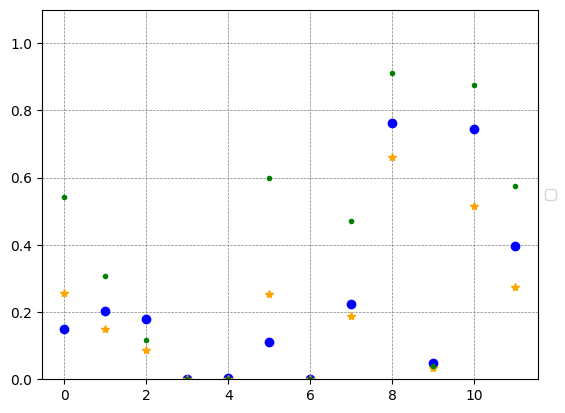

In [135]:
#plt.plot(constant_metrics_dict["hsic_dist"][3])
#plt.plot(constant_metrics_dict["dcor_dist"][3])
#plt.plot(constant_metrics_dict["pearson_dist"][3])
#plt.legend(["hsic","dcor","pearson"])

plt.plot(constant_metrics_dict["hsic_dist"][6],"o", color='blue',)
plt.plot(constant_metrics_dict["dcor_dist"][6],"*", color='orange')
plt.plot(constant_metrics_dict["pearson_dist"][6],".", color='green')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylim([0, 1.1])

#plt.plot(constant_metrics_dict["dtw_dist"][1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
constant_metrics_dict["dcor_dist"][6].round(3)

General total time series data...
Number of simplices: 1585
Number of simplices: 1585
Number of simplices: 1585
Number of simplices: 1585


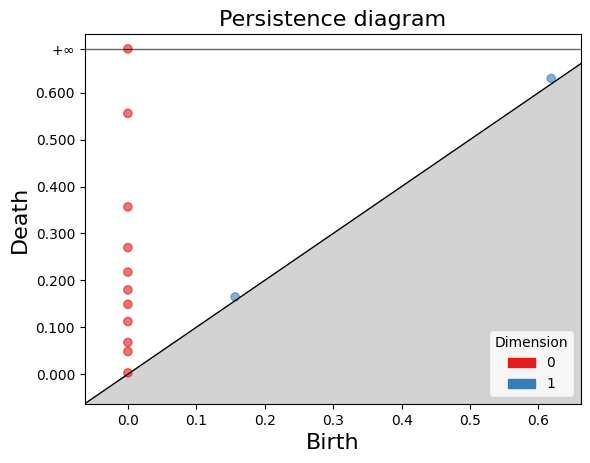

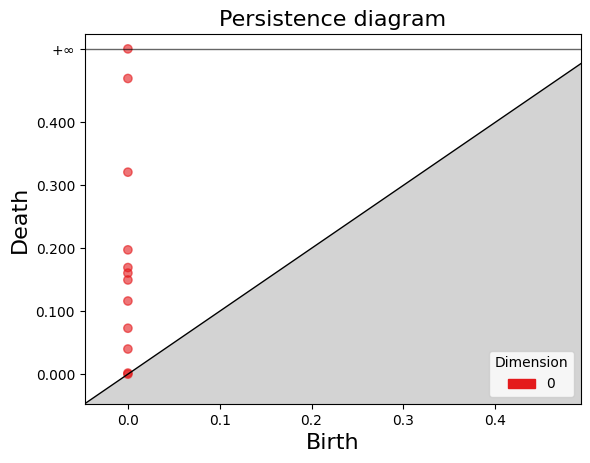

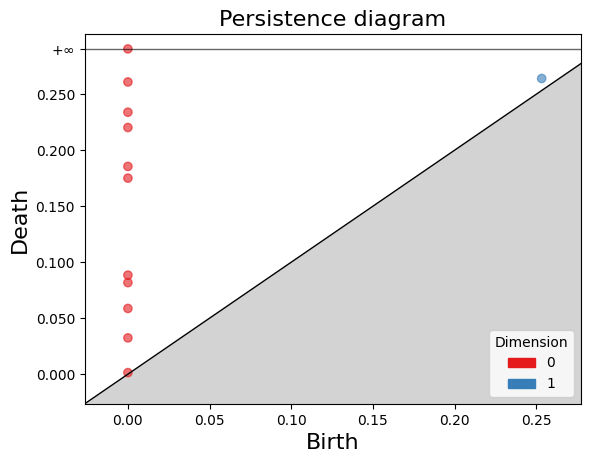

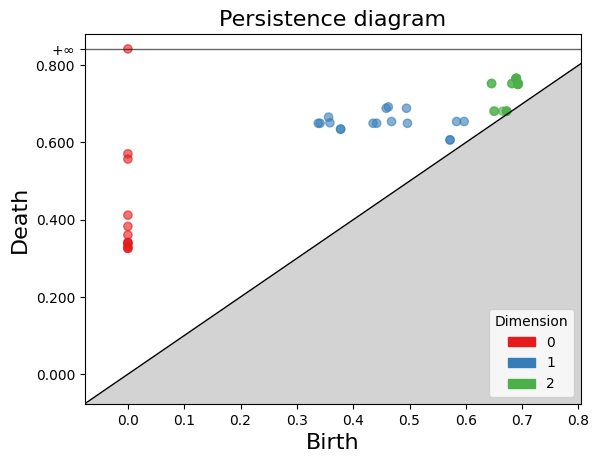

In [117]:
constant_metrics_dict = create_metric_matrix(results_df)

# HSIC correlation-based complex
print("General total time series data...")
simplex_hsic, diag_hsic = build_rips_complex(constant_metrics_dict["hsic_dist"])
simplex_cor, diag_cor = build_rips_complex(constant_metrics_dict["pearson_dist"])
simplex_dcor, diag_dcor = build_rips_complex(constant_metrics_dict["dcor_dist"])
simplex_dtw, diag_dtw = build_rips_complex(constant_metrics_dict["dtw_dist"])


<Axes: title={'center': 'Persistence barcode'}>

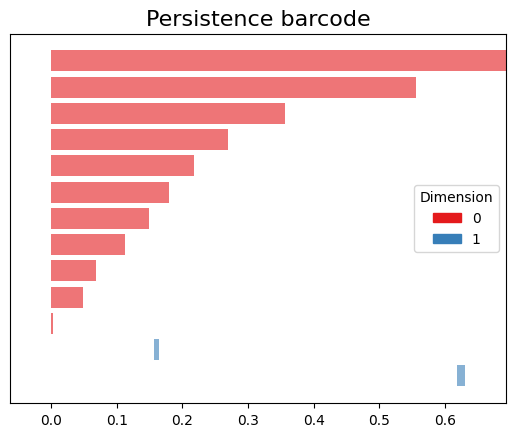

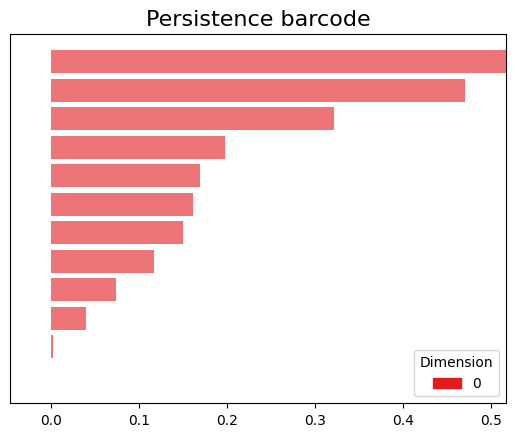

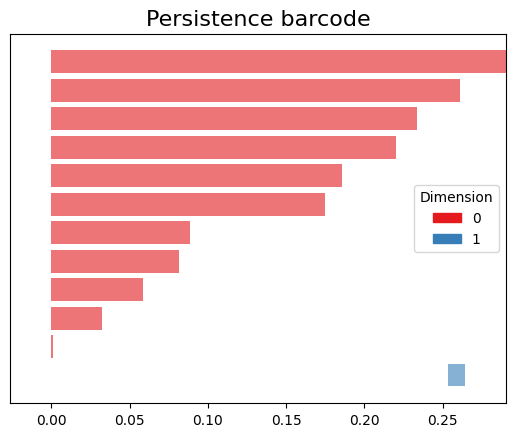

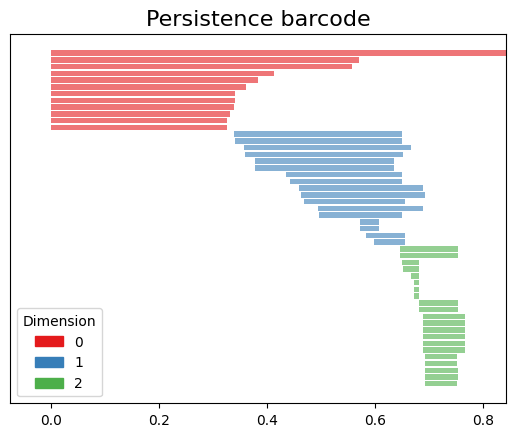

In [118]:
gd.plot_persistence_barcode(simplex_hsic.persistence())
gd.plot_persistence_barcode(simplex_cor.persistence())
gd.plot_persistence_barcode(simplex_dcor.persistence())
gd.plot_persistence_barcode(simplex_dtw.persistence())

In [18]:
def describe_persistence_features_table(stree, variables, min_lifetime=0.005, dimension=None):
    """
    Describe persistence features and return results as a pandas DataFrame.
    
    Parameters:
    - stree: GUDHI SimplexTree object
    - variables: list of variable names
    - min_lifetime: minimum lifetime threshold to include features
    - dimension: optional dimension filter
    
    Returns:
    - pandas DataFrame with persistence features
    """
    diagram = stree.persistence()
    pairs = stree.persistence_pairs()
    
    def name_simplex(simplex):
        if not simplex:
            return "∞ (persists forever)"
        named_nodes = [variables[i] for i in simplex]
        if len(simplex) == 1:
            return f"Node '{named_nodes[0]}'"
        elif len(simplex) == 2:
            return f"Edge between '{named_nodes[0]}' and '{named_nodes[1]}'"
        elif len(simplex) == 3:
            nodes_str = ", ".join(f"'{n}'" for n in named_nodes)
            return f"Triangle formed by {nodes_str}"
        else:
            nodes_str = ", ".join(f"'{n}'" for n in named_nodes)
            return f"{len(simplex)-1}D simplex with nodes {nodes_str}"
    
    # Collect feature data
    features_data = []
    
    for i, ((dim, lifetime), (birth_simplex, death_simplex)) in enumerate(zip(diagram, pairs)):
        birth_time = lifetime[0] if birth_simplex else float('inf')
        death_time = lifetime[1] if death_simplex else float('inf')
        feature_lifetime = death_time - birth_time
        
        # Apply filters
        if feature_lifetime >= min_lifetime:
            if dimension is None or dim == dimension:
                features_data.append({
                    'Feature_ID': i,
                    'Dimension': dim,
                    'Birth_Time': birth_time,
                    'Death_Time': death_time if death_time != float('inf') else '∞',
                    'Lifetime': feature_lifetime if feature_lifetime != float('inf') else '∞',
                    'Birth_From': name_simplex(birth_simplex),
                    'Death_From': name_simplex(death_simplex)
                })
    
    # Create DataFrame
    df_features = pd.DataFrame(features_data)
    
    # Sort by lifetime (descending) for most persistent features first
    if not df_features.empty:
        # Handle infinity values for sorting
        df_features['Lifetime_Sort'] = df_features['Lifetime'].apply(
            lambda x: float('inf') if x == '∞' else x
        )
        df_features = df_features.sort_values('Lifetime_Sort', ascending=False).drop('Lifetime_Sort', axis=1)
        df_features = df_features.reset_index(drop=True)
    
    return df_features


In [136]:
describe_persistence_features_table(simplex_dcor, df_cleaned.columns)

,Feature_ID,Dimension,Birth_Time,Death_Time,Lifetime,Birth_From,Death_From
0,1,0,0.000000,∞,∞,Node 'tau_wind_surge',Edge between 'tau_wind_surge' and 'psi_x'
1,11,0,0.000000,∞,∞,Node 'v',∞ (persists forever)
2,2,0,0.000000,0.260906,0.260906,Node 'os_y',Edge between 'os_y' and 'os_x'
3,3,0,0.000000,0.233878,0.233878,Node 'psi_x',Edge between 'tau_wind_surge' and 'os_y'
4,4,0,0.000000,0.220239,0.220239,Node 'os_x',Edge between 'psi_x' and 'chi_desired_deg'
5,5,0,0.000000,0.185481,0.185481,Node 'tau_wind_yaw',Edge between 'tau_wind_yaw' and 'os_x'
6,6,0,0.000000,0.175023,0.175023,Node 'u',Edge between 'u' and 'u_current'
7,7,0,0.000000,0.088401,0.088401,Node 'chi_desired_deg',Edge between 'tau_wind_yaw' and 'v_current'
8,8,0,0.000000,0.08175,0.08175,Node 'tau_wind_sway',Edge between 'tau_wind_sway' and 'v'
9,9,0,0.000000,0.058664,0.058664,Node 'v_current',Edge between 'tau_wind_yaw' and 'tau_wind_sway'


In [137]:
simplex_dcor.persistence_pairs()

[([4], [4, 3]),
 ([9], [9, 3]),
 ([1], [1, 0]),
 ([3], [9, 1]),
 ([0], [3, 2]),
 ([11], [11, 0]),
 ([7], [7, 4]),
 ([2], [11, 5]),
 ([10], [10, 8]),
 ([5], [11, 10]),
 ([5, 3], [11, 9, 5]),
 ([8], [])]

In [141]:
simplex_dcor.persistence()

[(1, (0.2532686984061375, 0.2640164113695673)),
 (0, (0.0, inf)),
 (0, (0.0, 0.26090555857576225)),
 (0, (0.0, 0.23387845116093653)),
 (0, (0.0, 0.22023943615236008)),
 (0, (0.0, 0.1854812208000003)),
 (0, (0.0, 0.17502329552828377)),
 (0, (0.0, 0.08840070691768609)),
 (0, (0.0, 0.08175003115412272)),
 (0, (0.0, 0.058663985248081585)),
 (0, (0.0, 0.032389309613602424)),
 (0, (0.0, 0.0013661081042529721))]

In [98]:
def create_persistence_information(simplex_tree):
    ordered_death_persistence_pairs=[]
    persistence_pairs=[]
    persistence_information=[]
    for persistence_pair in simplex_tree.persistence():
        ordered_death_persistence_pairs.append(persistence_pair)
    ordered_death_persistence_pairs.sort(key=lambda x: x[1][1] if x[1][1] != float('inf') else float('inf'), reverse=False)

    for i in simplex_tree.persistence_pairs():
        persistence_pairs.append(i)
    #make a tuple structure with each element of ordered_death_persistence_pairs and persistence_pairs
    persistence_information = list(zip(ordered_death_persistence_pairs, persistence_pairs))
    return persistence_information

In [21]:

def visualize_rips_1_skeleton(simplex_tree, variable_names, title=""):
    """
    Visualize the 1-skeleton (nodes and edges) of a Rips complex using variable names as labels.

    Parameters:
    - simplex_tree: GUDHI SimplexTree object
    - variable_names: list of variable names in the same order as used to build the distance matrix
    """
    G = nx.Graph()

    for simplex, _ in simplex_tree.get_simplices():
        if len(simplex) == 1:
            node = simplex[0]
            G.add_node(variable_names[node])
        elif len(simplex) == 2:
            u, v = simplex
            G.add_edge(variable_names[u], variable_names[v])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=1.5)  # Increase k for more spacing
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2.5)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    plt.title("1-Skeleton of Vietoris–Rips Complex (Variable Labels)" + title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [22]:
def create_cooccur_matrix(simplex_tree):
    """
    Create co-occurrence matrix from a simplex tree.
    
    Parameters:
    - simplex_tree: GUDHI SimplexTree object
    
    Returns:
    - co_occurrence: numpy array representing co-occurrence matrix
    """
    # Convert generator to list to access simplex and filtration values
    simplex_filtration = list(simplex_tree.get_filtration())
    filtrations=[]
    # Extract vertices and build proper co-occurrence matrix
    vertices = sorted({v for simplex, filtration in simplex_filtration for v in simplex})
    
    vertex_index = {v: i for i, v in enumerate(vertices)}
    n = len(vertices)
    co_occurrence = np.zeros((n, n))
    filtrations=[]
    for simplex, filtration in simplex_filtration:
        filtrations.append(filtration)
        for i in range(len(simplex)):
            for j in range(i + 1, len(simplex)):
                vi, vj = vertex_index[simplex[i]], vertex_index[simplex[j]]
                co_occurrence[vi][vj] += 1
                co_occurrence[vj][vi] += 1
    
    return co_occurrence, vertices

In [129]:
def merge_vertex(simplex_death,updated_vertex_dictionary):
    vertex_coordinate1=updated_vertex_dictionary[simplex_death[0]]
    vertex_coordinate2=updated_vertex_dictionary[simplex_death[1]]
    updated_coordinate= ((vertex_coordinate1[0] + vertex_coordinate2[0])/2,  (vertex_coordinate1[1] + vertex_coordinate2[1])/2) #midpoint of all points in simplex_death
    for node in simplex_death:
        updated_vertex_dictionary[node] = updated_coordinate
    
    return updated_vertex_dictionary

def get_simplex_coordinates(simplex_tree,distance_matrix,cluster_size=2): #distance matrix will be used in future, kept in function as a reminer
    
    #Create clustering based on co_occurrence matrix(returns matrix and vertices)
    coordinate_dictionary = {}
    co_occurrence, vertices = create_cooccur_matrix(simplex_tree)
    clustering = AgglomerativeClustering(
                n_clusters=cluster_size, 
                metric="euclidean",
                linkage='ward'
            )
    labels = clustering.fit_predict(co_occurrence)
    num_clusters = len(set(labels))
    cluster_centers = [
        (3 * np.cos(2 * np.pi * i / num_clusters), 3 * np.sin(2 * np.pi * i / num_clusters)) 
        for i in range(num_clusters)
    ]
    cluster_members = defaultdict(list)
    for v, label in zip(vertices, labels):
        cluster_members[label].append(v)
    colors = plt.cm.Set3(np.linspace(0, 1, max(num_clusters, 3)))
    vertex_colors = {}
    for label, members in cluster_members.items():
        cx, cy = cluster_centers[label]
        cluster_color = colors[label % len(colors)]  # Get color for this cluster
        if len(members) == 1:
            coordinate_dictionary.update({members[0]:(cx, cy)})
            vertex_colors[members[0]] = cluster_color  # Assign color to single member
        else:
            radius = 1.0
            angle_step = 2 * np.pi / len(members)
            for i, v in enumerate(members):
                angle = i * angle_step
                x = cx + radius * np.cos(angle)
                y = cy + radius * np.sin(angle)
                coordinate_dictionary.update({v:(x,y)}) 
            for v in members:
                vertex_colors[v] = cluster_color 
    #create (x,y) positions for every vertex. These positions are made as cocentric circles. Position based on the distance matrix
    #Once all cooredinates are made create a dictionary where the vertices are 
    return coordinate_dictionary, vertex_colors

In [130]:
def visualize_clustered_simplicial_complex(simplex_tree, persistence_information, variable_names, distance_matrix, filtration_threshold=0.01, 
                                         clusters=3, show_labels=True):
    """
    Visualize a clustered simplicial complex with filtration-based rendering.
    
    Parameters:
    - simplex_filtration: list of (simplex, filtration_value) tuples from simplex_tree.get_filtration()
    - variable_names: list of variable names
    - filtration_threshold: threshold for showing solid vs dotted elements
    - min_cluster_size: minimum size for a cluster
    - show_labels: whether to show variable labels
    """
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_aspect('equal')
    ax.axis('off')
    original_coordinate_dictionary,vertex_colors=get_simplex_coordinates(simplex_tree,distance_matrix,clusters)
    updated_vertex_dictionary=original_coordinate_dictionary.copy()
    triangles_within_threshold=0
    edges_within_threshold = 0
    for feature in persistence_information:
        dimension=feature[0][0]
        birth=feature[0][1][0]
        death=feature[0][1][1]
        if dimension==0: #dimension 0, vertex
            simplex_birth=feature[1][0][0]
            simplex_death=feature[1][1]
            if filtration_threshold > death:
                updated_vertex_dictionary=merge_vertex(simplex_death,updated_vertex_dictionary)   
        if dimension ==1: #edges
            if (filtration_threshold < death) and (filtration_threshold >= birth):
                simplex_birth=feature[1][0]
                x_points=[updated_vertex_dictionary[simplex_birth[0]][0],updated_vertex_dictionary[simplex_birth[1]][0]]
                y_points=[updated_vertex_dictionary[simplex_birth[0]][1],updated_vertex_dictionary[simplex_birth[1]][1]]
                ax.plot(x_points,y_points,color="blue",linewidth=2)
                edges_within_threshold += 1
        if dimension==2: #triangles
            if (filtration_threshold < death) and (filtration_threshold > birth):
                simplex_birth=feature[1][0]
                triangle_points = np.array([updated_vertex_dictionary[node] for node in simplex_birth])
                triangles_within_threshold += 1
                
                # Create triangle polygon
                triangle = plt.Polygon(triangle_points, color="lightgreen", edgecolor="black", alpha=0.5)
                ax.add_patch(triangle)
            
    # Step 10: Draw vertices with cluster colors
    for v, (x, y) in updated_vertex_dictionary.items():
        ax.scatter(x, y, s=400, c=[vertex_colors[v]], edgecolors='black', 
                  linewidth=2, zorder=10)
        
        if show_labels:
            position_to_nodes = defaultdict(list)
            for v, (x, y) in updated_vertex_dictionary.items():
                # Round coordinates to handle floating point precision
                pos_key = (round(x, 6), round(y, 6))
                position_to_nodes[pos_key].append(v)
            for pos_key, vertices in position_to_nodes.items():
                x, y = pos_key
                if len(vertices) == 1:
                    # Single vertex - use normal styling
                    v = vertices[0]
                    label = variable_names[v] if v < len(variable_names) else str(v)
                    ax.text(x, y + 0.1, label, ha='center', va='bottom', 
                        fontsize=9, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
                else:
                    # Multiple vertices at same position - stack labels vertically
                    labels = []
                    for v in sorted(vertices):  # Sort for consistent ordering
                        label = variable_names[v] if v < len(variable_names) else str(v)
                        labels.append(label)
                    
                    stacked_label = '\n'.join(labels)
                    ax.text(x, y + 0.15, stacked_label, ha='center', va='bottom', 
                        fontsize=8, fontweight='bold', linespacing=1.2,
                        bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', 
                                    alpha=0.9, edgecolor='darkblue', linewidth=1))

    # Step 11: Add legend and statistics
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor=vertex_colors[i % len(vertex_colors)], 
                   markersize=12, label=f'Cluster {i} ')
        for i in range(clusters)
    ]
    
    # Add filtration legend
    legend_elements.extend([
        plt.Line2D([0], [0], color='blue', linewidth=2.5, label=f'Edges >= {filtration_threshold:.3f}'),
        plt.Line2D([0], [0], color='gray', linestyle=':', linewidth=1, label="Filtration Threshold"),
        plt.Polygon([(0, 0)], color='skyblue', alpha=0.5, label='Triangles'),
        plt.Polygon([(0, 0)], color='lightgreen', alpha=0.4, label='Higher simplices')
    ])
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Add statistics
    stats_text = f"""Filtration Statistics:
    Edges: {edges_within_threshold}
    Triangles: {triangles_within_threshold}"""
    
    legend_height = len(legend_elements) * 0.04  # Estimate legend height
    stats_y_position = max(0.85 - legend_height, 0.02)  # Don't go below 2% of plot

    ax.text(0.02, stats_y_position, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.8))
    # Use suptitle instead of title for better spacing
    fig.suptitle(f"Clustered Simplicial Complex (Filtration ≤ {filtration_threshold})", 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Leave space for the suptitle
    plt.show()



/home/manret/SComplex/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


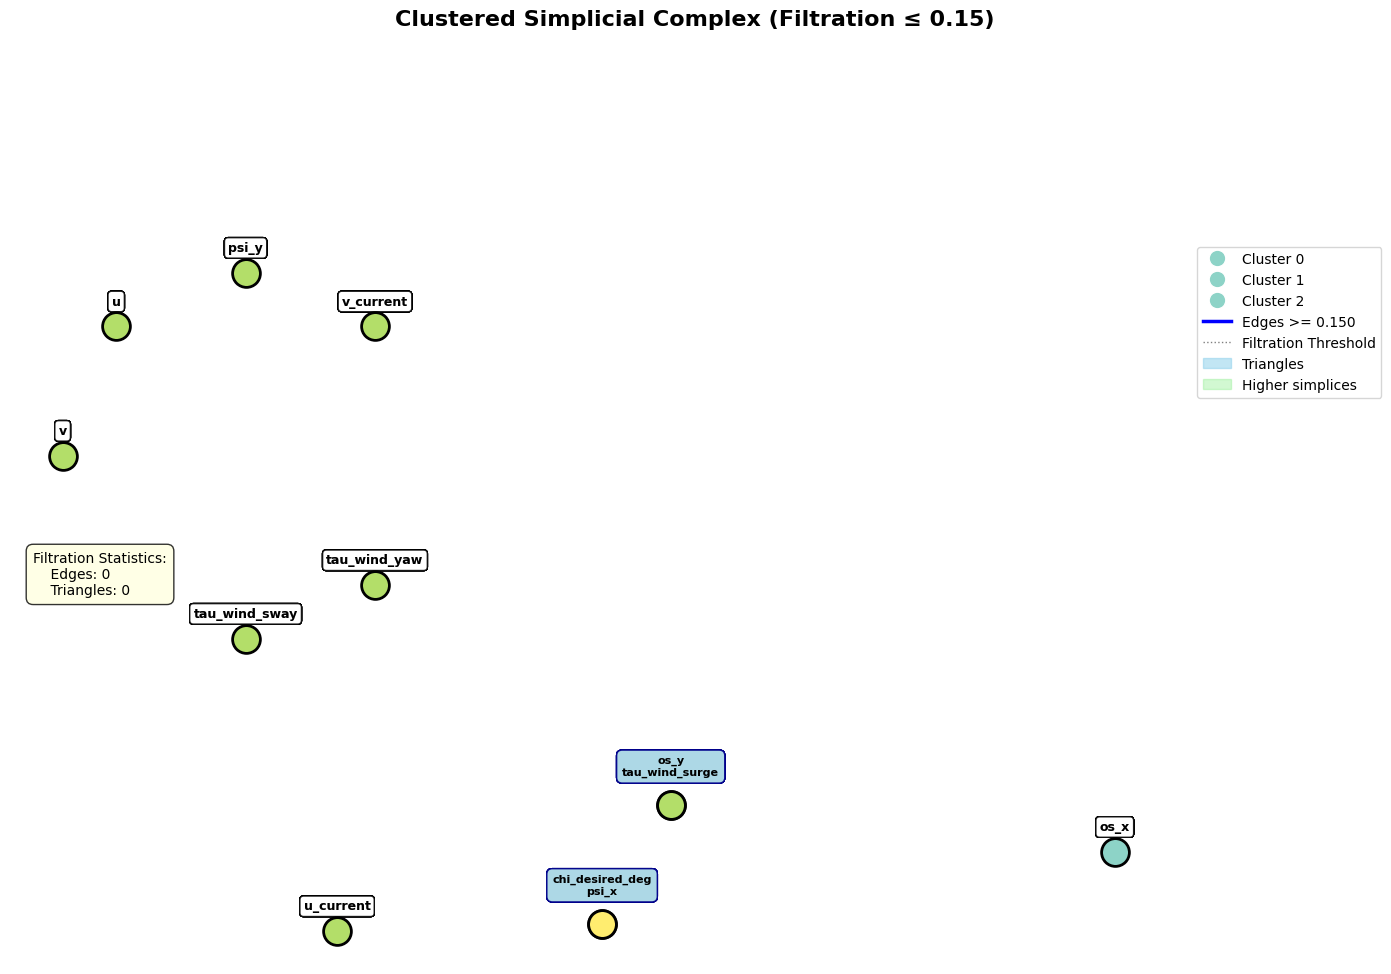

In [142]:
persistence_information=create_persistence_information(simplex_dcor)
visualize_clustered_simplicial_complex(simplex_dcor,persistence_information, df_cleaned.columns, constant_metrics_dict["dcor_dist"], filtration_threshold=0.15)

In [482]:
def build_correlation_matrix(df, value_column):
    matrix = df.pivot(index='Var1', columns='Var2', values=value_column)
    matrix_full = matrix.copy()

    # Fill in the lower triangle to make it symmetric
    for i in matrix.index:
        for j in matrix.columns:
            if pd.isna(matrix.at[i, j]):
                if j in matrix.index and i in matrix.columns:
                    matrix_full.at[i, j] = matrix.at[j, i]

    # Fill diagonal with 1.0
    for var in set(df['Var1']).union(set(df['Var2'])):
        matrix_full.at[var, var] = 1.0

    # Ensure symmetry
    matrix_full = matrix_full.combine_first(matrix_full.T)

    return matrix_full


In [483]:

pearson_matrix = build_correlation_matrix(results_df, 'Pearson')
distance_matrix = build_correlation_matrix(results_df, 'Distance_Correlation')
dtw_matrix=build_correlation_matrix(results_df, "DTWDistance")
hsic_matrix=build_correlation_matrix(results_df,"HSIC")
hsic_matrix=hsic_matrix.replace(np.nan,0) #is this the correct way to do it?
